# Data Preparation for local training

-----------------------
## 3. Prepare imagery

SpaceNet 3 and SpaceNet 5 data formats are slightly different, due to extra post-processing performed on the SpaceNet 5 imagery.  The RGB 3-band pan-sharpened imagery (PS-RGB) for SpaceNet 3 was distributed in the native 16-bit data format.  In SpaceNet 5 the RGB 3-band pan-sharpened imagery utilized the Maxar DRA (Dynamic Range Adjusted) product which seeks to equalize color scales, and yields an 8-bit image.  The pan-sharpened 8-band multispectral images (PS-MS) are prepared the same for both challenges, so we will utilize this data for training and testing.  

While we lose a significant amount of information by utilizing only a subset of the multispectral bands, for ease of exploration we extract the 8-bit RGB imagery from the 16-bit multispectral imagery, where RGB corresponds to bands 5,3,2, respectively.  This is accomplished via the `create_8bit_images.py` script.  In this example, we rescale the image to the 2nd and 98th percentile of pixel values when converting to 8-bit. The script below should be run for all 6 training areas of interest (AOIs): AOI_2_Vegas, AOI_3_Paris, AOI_4_Shanghai, AOI_5_Khartoum, AOI_7_Moscow, AOI_8_Mumbai.
    
    # SN3
    python /path/to/cresi/cresi/data_prep/create_8bit_images.py \
        --indir=/path/to/data/SN3_roads/AOI_4_Shanghai/PS-MS \
        --outdir=/path/to/data/cresi_data/8bit/PS-RGB \
        --rescale_type=perc \
        --percentiles=2,98 \
        --band_order=5,3,2

    # SN5
    python /path/to/cresi/cresi/data_prep/create_8bit_images.py \
        --indir=/path/to/data/SN5_roads/AOI_7_Moscow/PS-MS \
        --outdir=/path/to/data/cresi_data/8bit/PS-RGB \
        --rescale_type=perc \
        --percentiles=2,98 \
        --band_order=5,3,2


In the following we assume a run inside the docker container that maps the root repo dir in the host volume into /workspace in the docker.

In [4]:
%cd /workspace/cresi/data_prep
%run create_8bit_images.py --help

/workspace/cresi/data_prep
usage: create_8bit_images.py [-h] [--indir INDIR] [--outdir OUTDIR] [--command_file_loc COMMAND_FILE_LOC] [--rescale_type RESCALE_TYPE] [--band_order BAND_ORDER] [--percentiles PERCENTILES] [--max_zero_frac MAX_ZERO_FRAC] [--n_threads N_THREADS]

optional arguments:
  -h, --help            show this help message and exit
  --indir INDIR
  --outdir OUTDIR
  --command_file_loc COMMAND_FILE_LOC
  --rescale_type RESCALE_TYPE
                        clip, perc, tot_8band, tot_3band
  --band_order BAND_ORDER
                        ',' separated list set to '' to use default band order, 1-indexed
  --percentiles PERCENTILES
                        ',' separated list of min,max percentiles
  --max_zero_frac MAX_ZERO_FRAC
                        max percentage of image we allow to be null
  --n_threads N_THREADS
                        num threads for multiprocessing


### Convert the images for Shanghai

In [ ]:
%run create_8bit_images.py \
--input=/data/sn3.upabove.aegean.ai/AOI_4_Shanghai/PS-MS \
--outdir=/data/sn3.upabove.aegean.ai/cresi_data/8bit/PS-RGB \
--rescale_type=perc \
--percentiles=2,98 \
--band_order=5,3,2

-----------------------
## 2. Explore images and geojsons

In [9]:
# First, let's inspect an image

import os
import cv2
import skimage.io
import numpy as np
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

data_root_dir = '/data/sn3.upabove.aegean.ai/AOI_4_Shanghai/PS-MS'
im_path_sample = os.path.join(
     data_root_dir, 'SN3_roads_train_AOI_4_Shanghai_PS-MS_img1008.tif')

print(im_path_sample)

# view MS image
fig_width, fig_height = 10, 10
im = cv2.imread(im_path_sample, 1)
print ("im.shape:", im.shape)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(im)#cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
ax.axis('off')

data_root_dir = '/data/sn3.upabove.aegean.ai/cresi_data/8bit/PS-RGB'
im_path_sample = os.path.join(
    data_root_dir, 'SN3_roads_train_AOI_4_Shanghai_PS-MS_img1008.tif')

# view RGB image
fig_width, fig_height = 10, 10
im = cv2.imread(im_path_sample, 1)
print ("im.shape:", im.shape)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
ax.axis('off')

/data/sn3.upabove.aegean.ai/AOI_4_Shanghai/PS-MS/SN3_roads_train_AOI_4_Shanghai_PS-MS_img1008.tif


AttributeError: 'NoneType' object has no attribute 'shape'

inGDF.columns: Index(['OBJECTID', 'bridge', 'highway', 'osm_id', 'surface', 'lanes',
       'inferred_speed_mph', 'inferred_speed_mps', 'origarea', 'origlen',
       'partialDec', 'truncated', 'geometry'],
      dtype='object')

sample gdf row: OBJECTID                                                           5940
bridge                                                             None
highway                                                        tertiary
osm_id                                                      6.83692e+08
surface                                                           paved
lanes                                                                 1
inferred_speed_mph                                                   30
inferred_speed_mps                                              13.4112
origarea                                                              0
origlen                                                               0
partialDec                         

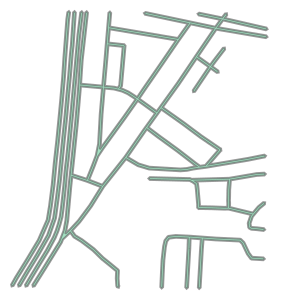

In [30]:
# Visualize geojsons

data_root_dir = '/data/sn3.upabove.aegean.ai/AOI_4_Shanghai/geojson_roads'

geojson_path_sample = os.path.join(
    data_root_dir, 'SN3_roads_train_AOI_4_Shanghai_geojson_roads_img1008.geojson')

# define road buffer width 
bufferDistanceMeters = 2

# get gdf_buffer
inGDF = gpd.read_file(geojson_path_sample)
print ("inGDF.columns:", inGDF.columns)
print ("\nsample gdf row:", inGDF.iloc[0])

# # project via osmnx
projGDF = ox.project_gdf(inGDF)
# get bounds
bounds = projGDF.geometry.total_bounds
print("\nprojGDF.geometry.total_bounds:", bounds)
# get extent
print("\nx_extent =", bounds[2] - bounds[0])
print("y_extent =", bounds[3] - bounds[1])

# explore buffer
#   https://shapely.readthedocs.io/en/latest/manual.html#object.buffer
gdf_utm_buffer = projGDF.copy()
# perform Buffer to produce polygons from Line Segments
gdf_utm_buffer['geometry'] = gdf_utm_buffer.buffer(bufferDistanceMeters, 1)
gdf_utm_dissolve = gdf_utm_buffer.dissolve(by='truncated')
gdf_utm_dissolve.crs = gdf_utm_buffer.crs
gdf_buffer = gdf_utm_dissolve.to_crs(inGDF.crs)
# display
gdf_utm_dissolve['geometry'][0]   

-----------------------
## 4. Create Masks

The `geojson_roads_speed` folder within each area of interest (AOI) directory contains road centerline labels along with estimates of safe travel speeds for each roadway (see https://github.com/CosmiQ/apls/blob/master/apls/road_speed.py for further details).  We'll use these centerline labels and speed estimates to create training masks. We assume a mask buffer of 2 meters, meaning that each roadway is assigned a total width of 4 meters.  Remember that the goal of our segmentation step is to detect road centerlines, so while this is not the precise width of the road, a buffer of 2 meters is an appropriate width for our segmentation model. We explore two options, continuous masks and multi-channel masks.

-----------------------
### 4.1. Continous Masks

One option for training a segmentation model is to create training masks where the value of the mask is proportional to the speed of the roadway. This can be accomplished by running the `speed_masks.py` script.  In the following example, we assume data is in: `/raid/data/spacenet/`

    # SN3
    python /path/to/cresi/cresi/data_prep/speed_masks.py \
        --geojson_dir=/path/to/data/SN3_roads/AOI_2_Vegas/geojson_roads_speed \
        --image_dir=/path/to/data/SN3_roads/AOI_2_Vegas/PS-MS \
        --output_conversion_csv=/path/to/data/cresi_data/cresi_train/SN3_roads_train_speed_conversion_continuous.csv \
        --output_mask_dir=/path/to/data/cresi_data/cresi_train/train_mask_continuous \
        --buffer_distance_meters=2

    # SN5
    python /path/to/cresi/cresi/data_prep/speed_masks.py \
        --geojson_dir=/path/to/data/SN5_roads/AOI_7_Moscow/geojson_roads_speed \
        --image_dir=/path/to/data/SN5_roads/AOI_7_Moscow/PS-MS \
        --output_conversion_csv=/path/to/data/cresi_data/cresi_train/SN5_roads_train_speed_conversion_continuous.csv \
        --output_mask_dir=/path/to/data/cresi_data/cresi_train/train_mask_continuous \
        --buffer_distance_meters=2


In [ ]:
%run speed_masks.py  \
--geojson_dir=/data/sn3.upabove.aegean.ai/AOI_4_Shanghai/geojson_roads \
--image_dir=/data/sn3.upabove.aegean.ai/AOI_4_Shanghai/PS-MS \
--output_conversion_csv_contin=/data/sn3.upabove.aegean.ai/cresi_data/cresi_train/SN3_roads_train_speed_conversion_continuous.csv \
--output_mask_dir_contin=/data/sn3.upabove.aegean.ai/cresi_data/cresi_train/train_mask_continuous \
--buffer_distance_meters=2 \
--label_type=SN3

Text(0.5, 1.0, 'Continuous Mask')

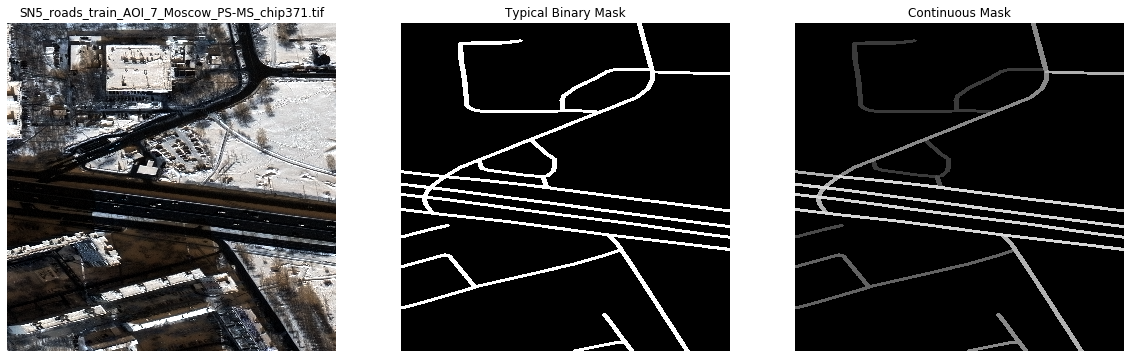

In [34]:
# Inspect files

im_dir = '/data/sn3.upabove.aegean.ai/cresi_data/8bit/PS-RGB'
mask_dir = '/data/sn3.upabove.aegean.ai/cresi_data/cresi_train/train_mask_continuous'
im_name = 'SN3_roads_train_AOI_4_Shanghai_PS-MS_img100.tif'
im_path = os.path.join(im_dir, im_name)
mask_contin_path = os.path.join(mask_dir, im_name)

# plot
fig, ((ax0, ax1, ax2)) = plt.subplots(1,3, figsize=(20,7))

# image
im = cv2.imread(im_path, 1)
ax0.imshow(cv2.imread(im_path, 1))
ax0.axis('off')
ax0.set_title(im_name)

# binary mask
ax1.imshow(255*np.clip(cv2.imread(mask_contin_path, 1), 0, 1))
ax1.axis('off')
ax1.set_title('Typical Binary Mask')

# continuous mask
ax2.imshow(cv2.imread(mask_contin_path, 1))
ax2.axis('off')
ax2.set_title('Continuous Mask')

### 4.2 Multi-channel masks

A second option for training a segmentation model is to create multi-channel training masks where each channel corresponds to a speed range.  In the script below we bin in 10 mph increments, for a total of 7 bins.  We also append the total binary mask (this aids in initial road extraction), for a total of 8 bins.

    # SN5 - binned
    python /path/to/cresi/cresi/data_prep/speed_masks.py \
        --geojson_dir=/path/to/data/SN5_roads/AOI_8_Mumbai/geojson_roads_speed \
        --image_dir=/path/to/data/SN5_roads/AOI_8_Mumbai/PS-MS \
        --output_conversion_csv=/path/to/data/cresi_data/cresi_train/SN5_roads_train_speed_conversion_binned.csv \
        --output_mask_dir=/path/to/data/cresi_data/cresi_train/train_mask_binned
        --output_mask_multidim_dir=/path/to/data/cresi_data/cresi_train/train_mask_binned_mc
        --buffer_distance_meters=2


multi-channel mask shape: (1300, 1300, 8)


Text(0.5, 1.0, 'Multi-channe››l Mask (colored by speed)')

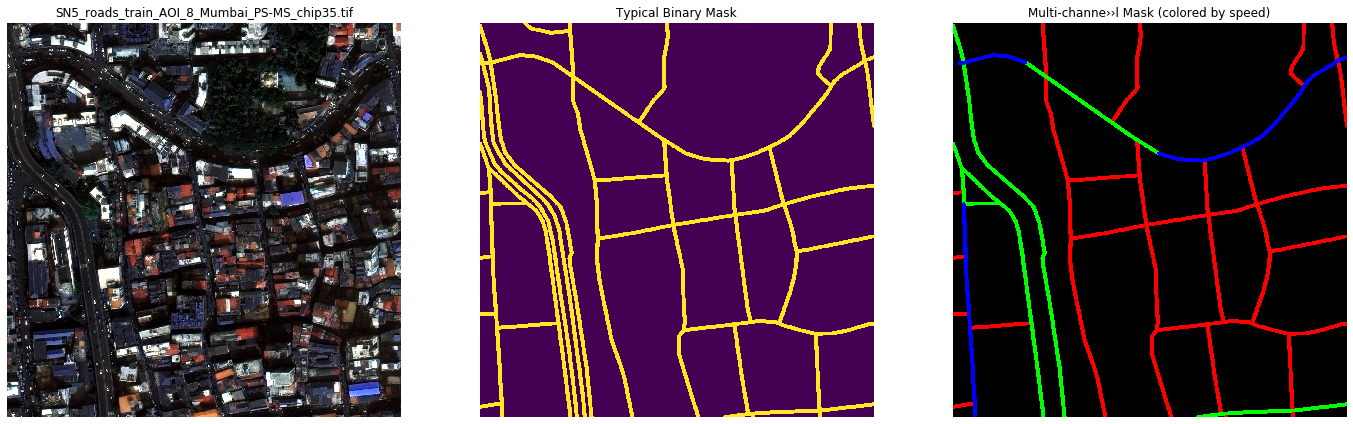

In [39]:
# Inspect files

im_dir = '/path/to/data/cresi_data/8bit/PS-RGB'
mask_dir = '/path/to/data/cresi_data/cresi_train/train_mask_binned_mc'
im_name = 'SN5_roads_train_AOI_8_Mumbai_PS-MS_chip35.tif'
im_path = os.path.join(im_dir, im_name)
mask_mc_path = os.path.join(mask_dir, im_name)

# plot
fig, ((ax0, ax1, ax2)) = plt.subplots(1,3, figsize=(24,9))

# image
im = cv2.imread(im_path, 1)
ax0.imshow(cv2.imread(im_path, 1))
ax0.axis('off')
ax0.set_title(im_name)

mask_mc = skimage.io.imread(mask_mc_path)
print("multi-channel mask shape:", mask_mc.shape)

# binary mask
ax1.imshow(mask_mc[:,:,-1])
ax1.axis('off')
ax1.set_title('Typical Binary Mask')

# 8 channel mask
z = ax2.imshow(mask_mc[:,:,2:5])
ax2.axis('off')
ax2.set_title('Multi-channe››l Mask (colored by speed)')

That's it! We now have the imagery and masks in hand for training deep learning segmentation models.